In [1]:
import os
import pyspark

conf = pyspark.SparkConf()
conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041') 
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/20 18:47:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType

In [3]:
spark_interactions = spark.read.json('shared/finals/swarali/goodreads_interactions_dedup.json')
spark_interactions.show()

+--------+--------------------+--------------------+-------+------+--------------------+--------------------+----------------------+--------------------+--------------------+
| book_id|          date_added|        date_updated|is_read|rating|             read_at|           review_id|review_text_incomplete|          started_at|             user_id|
+--------+--------------------+--------------------+-------+------+--------------------+--------------------+----------------------+--------------------+--------------------+
|34684622|Tue Oct 17 09:40:...|Tue Oct 17 09:40:...|  false|     0|                    |a53868823f065a0e2...|                      |                    |8842281e1d1347389...|
|34536488|Fri Oct 13 07:19:...|Fri Oct 13 07:19:...|  false|     0|                    |9f08c5f991f87f3b7...|                      |                    |8842281e1d1347389...|
|34017076|Fri Oct 06 09:32:...|Fri Oct 06 09:32:...|  false|     0|                    |14da595c5b0c38b12...|                

In [9]:
interactions_df = spark_interactions.limit(10000)

In [10]:
from pyspark.sql.functions import col 

columns = ["user_id", "book_id", "review_id", "is_read", "rating", "review_text_incomplete", "date_added", "date_updated", "read_at", "started_at"]

average_rating_per_user = interactions_df.groupBy("user_id").agg({"rating": "avg"})

# Counting the number of books read per user
books_read_per_user = interactions_df.filter(col("is_read") == True).groupBy("user_id").count()

# Perform more analysis as needed based on your requirements

# Show the results
average_rating_per_user.show()


+--------------------+-------------------+
|             user_id|        avg(rating)|
+--------------------+-------------------+
|8842281e1d1347389...| 2.1169652265542678|
|72fb0d0087d28c832...|  3.213235294117647|
|ab2923b738ea3082f...| 3.2794117647058822|
|d986f354a045ffb91...|0.47249190938511326|
|7504b2aee1ecb5b28...| 3.1861702127659575|
|f8a89075dc6de1485...|0.30498266106953825|
|47d4a49ae9ee68ae7...|  3.641025641025641|
|704eb93a316aff687...| 0.8943661971830986|
|06316bec7a49286f1...|  4.115702479338843|
|012515e5802b2e0f4...| 2.2464285714285714|
|fe0df2eff573e75c0...|0.08064516129032258|
|1711b2a40d154603f...| 1.4844357976653697|
|f4d16ea4ac59af59d...|  2.024390243902439|
|220ef9c058a2132e6...|  4.021231422505308|
|01ec1a320ffded6b2...| 1.5900277008310248|
+--------------------+-------------------+



In [11]:
books_read_per_user.show()

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|8842281e1d1347389...|  482|
|72fb0d0087d28c832...|  103|
|ab2923b738ea3082f...|  191|
|d986f354a045ffb91...|  108|
|7504b2aee1ecb5b28...|  182|
|f8a89075dc6de1485...|  428|
|47d4a49ae9ee68ae7...|  105|
|704eb93a316aff687...|   37|
|06316bec7a49286f1...|  242|
|012515e5802b2e0f4...|  167|
|fe0df2eff573e75c0...|    4|
|1711b2a40d154603f...|  192|
|f4d16ea4ac59af59d...|   68|
|220ef9c058a2132e6...|  406|
|01ec1a320ffded6b2...|  288|
+--------------------+-----+



In [14]:
selected_data = interactions_df.select('book_id', 'rating', 'is_read')

selected_data.count()

10000

In [15]:
from pyspark.sql.functions import col, window

# Filter data for the user with the maximum book reads
filtered_df = interactions_df.filter(
    (col('is_read') == 'true') &
    (col('read_at') != '') & (col('read_at') != 'NULL') &
    (col('started_at') != '') & (col('started_at') != 'NULL')
)

filtered_df.count()

1097

In [16]:
filtered_df.show(truncate=False)

+--------+------------------------------+------------------------------+-------+------+------------------------------+--------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+--------------------------------+
|book_id |date_added                    |date_updated                  |is_read|rating|read_at                       |review_id                       |review_text_incomplete                                                                                                 

In [17]:
from pyspark.sql.functions import count, desc

book_counts = filtered_df.groupBy('user_id').agg(count('book_id').alias('book_count')).orderBy(desc('book_count'))

# Show the aggregated book counts
book_counts.show()

+--------------------+----------+
|             user_id|book_count|
+--------------------+----------+
|f8a89075dc6de1485...|       351|
|01ec1a320ffded6b2...|       236|
|7504b2aee1ecb5b28...|       151|
|8842281e1d1347389...|       110|
|d986f354a045ffb91...|        76|
|012515e5802b2e0f4...|        66|
|1711b2a40d154603f...|        48|
|704eb93a316aff687...|        18|
|47d4a49ae9ee68ae7...|        16|
|f4d16ea4ac59af59d...|        11|
|220ef9c058a2132e6...|         8|
|ab2923b738ea3082f...|         5|
|06316bec7a49286f1...|         1|
+--------------------+----------+



In [18]:
max_books_user = book_counts.first()['user_id']
print(max_books_user)


f8a89075dc6de14857561522e729f82c


In [19]:
max_books_data = filtered_df.filter(filtered_df.user_id == '8842281e1d1347389f2ab93d60773d4d')
max_books_data.show(truncate = False)

+--------+------------------------------+------------------------------+-------+------+------------------------------+--------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+--------------------------------+
|book_id |date_added                    |date_updated                  |is_read|rating|read_at                       |review_id                       |review_text_incomplete                                                                                                 

In [20]:
from pyspark.sql.functions import substring, concat_ws

# Assuming max_books_data contains the DataFrame for the user with the maximum books read

# Refining read_at and started_at columns to only include the date part in the desired format
refined_max_books_data = max_books_data \
    .withColumn('read_date', concat_ws(' ',
                                       substring(col('read_at'), 5, 6),
                                       substring(col('read_at'), 27, 4))) \
    .withColumn('started_date', concat_ws(' ',
                                          substring(col('started_at'), 5, 6),
                                          substring(col('started_at'), 27, 4))) \
    .select('user_id', 'book_id', 'review_id', 'is_read', 'rating', 'review_text_incomplete',
            'date_added', 'date_updated', 'read_date', 'started_date')

# Show the refined DataFrame
refined_max_books_data.show(truncate=False)


+--------------------------------+--------+--------------------------------+-------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+------------------------------+-----------+------------+
|user_id                         |book_id |review_id                       |is_read|rating|review_text_incomplete                                                                                                                                                                                                  

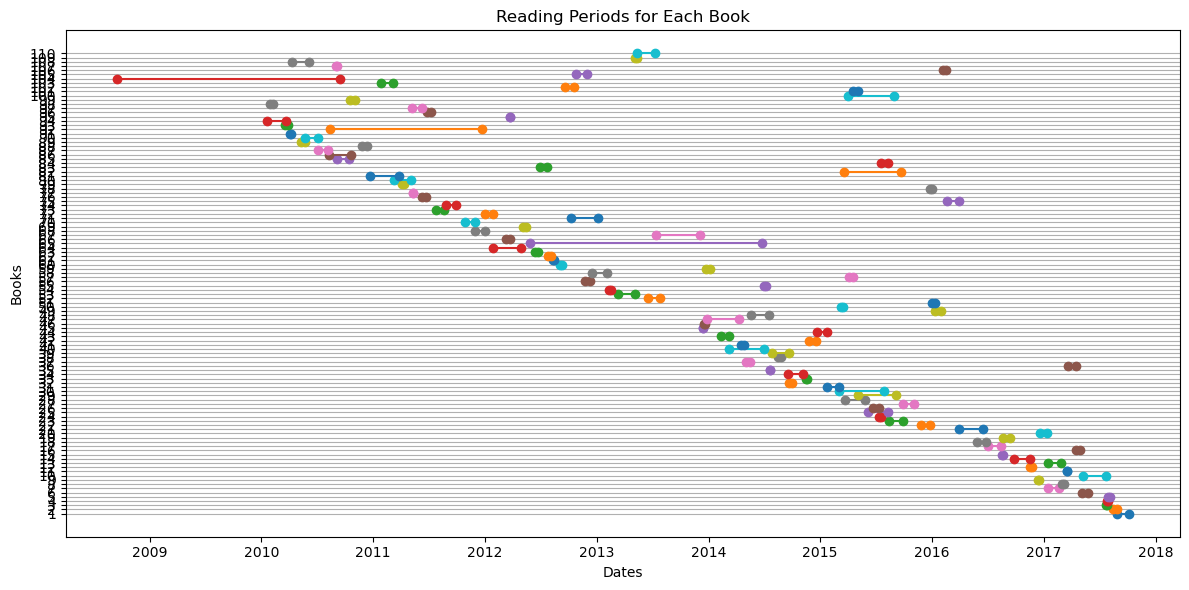

In [21]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
from pyspark.sql import functions as F

# Assuming your DataFrame is named 'df'
refined_max_books_data = refined_max_books_data.withColumn('read_date', F.to_date(F.unix_timestamp('read_date', 'MMM dd yyyy').cast('timestamp')))
refined_max_books_data = refined_max_books_data.withColumn('started_date', F.to_date(F.unix_timestamp('started_date', 'MMM dd yyyy').cast('timestamp')))

# Collect the data to the driver
data = refined_max_books_data.select('read_date', 'started_date').collect()

# Plotting
plt.figure(figsize=(12, 6))

# Plotting each row with a unique color
for i, row in enumerate(data):
    plt.plot([row['started_date'], row['read_date']], [i, i], marker='o')

plt.xlabel('Dates')
plt.yticks(range(len(data)), range(1, len(data) + 1))
plt.ylabel('Books')
plt.title('Reading Periods for Each Book')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


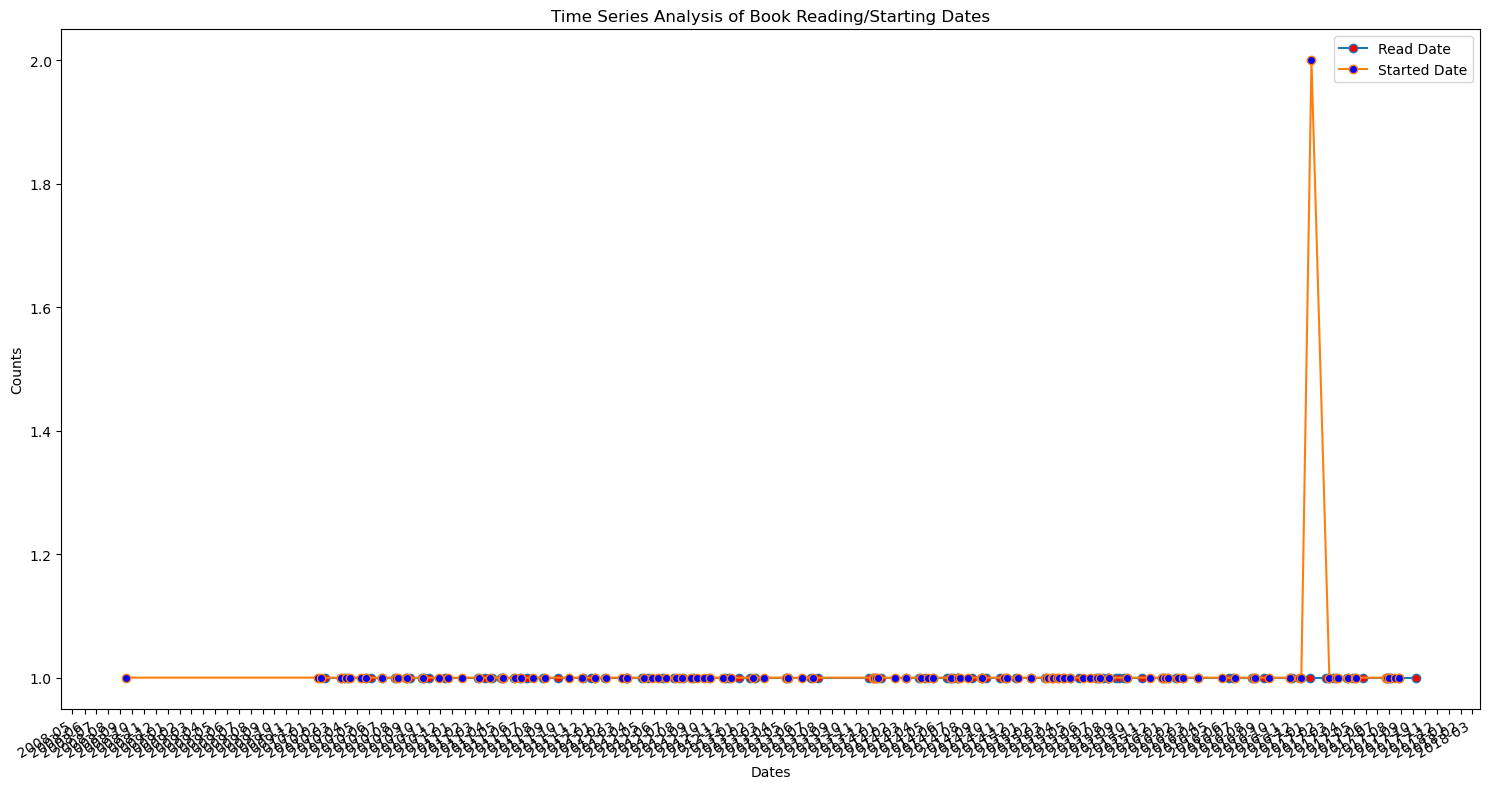

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql.functions import to_date
from collections import Counter
from datetime import datetime

# Assuming your DataFrame is named 'df'
refined_max_books_data = refined_max_books_data.withColumn('read_date', to_date(refined_max_books_data['read_date'], 'MMM dd yyyy'))
refined_max_books_data = refined_max_books_data.withColumn('started_date', to_date(refined_max_books_data['started_date'], 'MMM dd yyyy'))

# Collect the data to the driver
data = refined_max_books_data.select('read_date', 'started_date').collect()

# Extracting the dates and counting occurrences
read_date_counts = Counter([row['read_date'] for row in data])
started_date_counts = Counter([row['started_date'] for row in data])

# Separate the dates and counts
read_dates, read_counts = zip(*sorted(read_date_counts.items()))
started_dates, started_counts = zip(*sorted(started_date_counts.items()))

# Plotting
plt.figure(figsize=(15, 8))  # Larger figure size to accommodate for more dates

# Plotting with proper date handling and markers
plt.plot_date(read_dates, read_counts, '-o', label='Read Date', mfc='red')
plt.plot_date(started_dates, started_counts, '-o', label='Started Date', mfc='blue')

# Formatting the x-axis to handle dates better
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

plt.xlabel('Dates')
plt.ylabel('Counts')
plt.title('Time Series Analysis of Book Reading/Starting Dates')
plt.legend()
plt.tight_layout()  # Adjust subplot parameters to give the plot more room
plt.show()

# Genre based time series analysis

In [23]:
author_data = spark.read.json('shared/finals/swarali/goodreads_book_authors.json')
author_data.show()

+---------+--------------+-------------------+-------------+------------------+
|author_id|average_rating|               name|ratings_count|text_reviews_count|
+---------+--------------+-------------------+-------------+------------------+
|   604031|          3.98|   Ronald J. Fields|           49|                 7|
|   626222|          4.08|      Anita Diamant|       546796|             28716|
|    10333|          3.92|     Barbara Hambly|       122118|              5075|
|     9212|          3.68|    Jennifer Weiner|       888522|             36262|
|   149918|          3.82|      Nigel Pennick|         1740|                96|
|  3041852|          3.89|   Alfred J. Church|          947|                85|
|   215594|          4.17| Michael Halberstam|           23|                 6|
|    19158|          4.18|     Rachel Roberts|        13677|               486|
|  5807700|          3.99|         V.L. Locey|         3130|               986|
|  2983296|          3.48|Anton Szandor 

## genre data import

In [24]:
file_url = 'shared/finals/swarali/goodreads_book_genres_initial.json'
genre_data = spark.read.json(file_url)

genre_data.show(truncate = False)

+--------+------------------------------------------------------------+
|book_id |genres                                                      |
+--------+------------------------------------------------------------+
|5333265 |{NULL, NULL, NULL, NULL, 1, NULL, NULL, NULL, NULL, NULL}   |
|1333909 |{NULL, NULL, NULL, 219, 5, NULL, NULL, NULL, NULL, NULL}    |
|7327624 |{NULL, NULL, 31, 8, NULL, 1, NULL, 1, NULL, NULL}           |
|6066819 |{NULL, NULL, NULL, 555, NULL, 10, NULL, NULL, 23, NULL}     |
|287140  |{NULL, NULL, NULL, NULL, NULL, NULL, 3, NULL, NULL, NULL}   |
|287141  |{6, NULL, 1, 1, 9, NULL, NULL, NULL, NULL, 1}               |
|378460  |{NULL, NULL, NULL, 2, NULL, NULL, NULL, NULL, NULL, NULL}   |
|6066812 |{16, NULL, 32, 7, NULL, NULL, NULL, NULL, NULL, 8}          |
|34883016|{NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, 3, NULL}   |
|287149  |{NULL, NULL, NULL, NULL, 1, NULL, 24, NULL, NULL, NULL}     |
|6066814 |{NULL, NULL, NULL, 19, 38, 38, NULL, NULL, NULL, NULL}

In [25]:
genre_data.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- genres: struct (nullable = true)
 |    |-- children: long (nullable = true)
 |    |-- comics, graphic: long (nullable = true)
 |    |-- fantasy, paranormal: long (nullable = true)
 |    |-- fiction: long (nullable = true)
 |    |-- history, historical fiction, biography: long (nullable = true)
 |    |-- mystery, thriller, crime: long (nullable = true)
 |    |-- non-fiction: long (nullable = true)
 |    |-- poetry: long (nullable = true)
 |    |-- romance: long (nullable = true)
 |    |-- young-adult: long (nullable = true)



In [26]:
from pyspark.sql.functions import expr

# Pivot the DataFrame
df_pivoted = genre_data.select(
    "book_id",
    expr("coalesce(genres.fiction, 0) as fiction"),
    expr("coalesce(genres.`fantasy, paranormal`, 0) as `fantasy, paranormal`"),
    expr("coalesce(genres.`young-adult`, 0) as `young-adult`"),
    expr("coalesce(genres.`history, historical fiction, biography`, 0) as `history, historical fiction, biography`"),
    expr("coalesce(genres.`mystery, thriller, crime`, 0) as `mystery, thriller, crime`"),
    expr("coalesce(genres.romance, 0) as romance"),
    expr("coalesce(genres.children, 0) as children"),
    expr("coalesce(genres.`non-fiction`, 0) as `non-fiction`"),
    expr("coalesce(genres.`comics, graphic`, 0) as `comics, graphic`"),
    expr("coalesce(genres.poetry, 0) as poetry")
)


In [27]:
df_pivoted.show()

+--------+-------+-------------------+-----------+--------------------------------------+------------------------+-------+--------+-----------+---------------+------+
| book_id|fiction|fantasy, paranormal|young-adult|history, historical fiction, biography|mystery, thriller, crime|romance|children|non-fiction|comics, graphic|poetry|
+--------+-------+-------------------+-----------+--------------------------------------+------------------------+-------+--------+-----------+---------------+------+
| 5333265|      0|                  0|          0|                                     1|                       0|      0|       0|          0|              0|     0|
| 1333909|    219|                  0|          0|                                     5|                       0|      0|       0|          0|              0|     0|
| 7327624|      8|                 31|          0|                                     0|                       1|      0|       0|          0|              0|     1

In [28]:
df_pivoted.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- fiction: long (nullable = false)
 |-- fantasy, paranormal: long (nullable = false)
 |-- young-adult: long (nullable = false)
 |-- history, historical fiction, biography: long (nullable = false)
 |-- mystery, thriller, crime: long (nullable = false)
 |-- romance: long (nullable = false)
 |-- children: long (nullable = false)
 |-- non-fiction: long (nullable = false)
 |-- comics, graphic: long (nullable = false)
 |-- poetry: long (nullable = false)



In [29]:
from pyspark.sql.functions import col, explode, expr

# Assuming your initial DataFrame is named 'initial_df'
# Select book_id and explode each genre column into separate rows
exploded_df = df_pivoted.select(
    col("book_id"),
    explode(expr("map('fiction', fiction, 'fantasy, paranormal', `fantasy, paranormal`, 'young-adult', `young-adult`, 'history, historical fiction, biography', `history, historical fiction, biography`, 'mystery, thriller, crime', `mystery, thriller, crime`, 'romance', romance, 'children', children, 'non-fiction', `non-fiction`, 'comics, graphic', `comics, graphic`, 'poetry', poetry)"))
    .alias("genre", "count")
)

# Group by book_id and genre, aggregate the counts
result_df = exploded_df.groupBy("book_id", "genre").sum("count").withColumnRenamed("sum(count)", "count")

# Show the resulting DataFrame
result_df.show()


23/12/20 20:02:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/20 20:02:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------+--------------------+-----+
| book_id|               genre|count|
+--------+--------------------+-----+
| 2592648|         young-adult|    0|
| 1393555|              poetry|    0|
|16201706|history, historic...|    0|
|35452242|            children|    0|
| 5371240|             romance|    0|
|  780917|history, historic...|    1|
| 3631900|         young-adult|    1|
|20924358|         young-adult|    0|
|18628483|history, historic...|    0|
|14781355|             romance|    6|
|20193550|             romance|    0|
| 2097274|         young-adult|    0|
|25421507|history, historic...|    1|
|25414981|             romance|    0|
|16066754|mystery, thriller...|    0|
|25635138|             romance|    0|
|10315513|         non-fiction|    0|
|16074814| fantasy, paranormal|    1|
| 8425263| fantasy, paranormal|    0|
|13340336|         young-adult|    0|
+--------+--------------------+-----+
only showing top 20 rows



In [30]:
result_df = result_df.filter(col('count') != 0)
result_df.show()

23/12/20 20:03:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/20 20:03:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------+--------------------+-----+
| book_id|               genre|count|
+--------+--------------------+-----+
|  780917|history, historic...|    1|
| 3631900|         young-adult|    1|
|14781355|             romance|    6|
|25421507|history, historic...|    1|
|16074814| fantasy, paranormal|    1|
|18711342|history, historic...| 2429|
|10806005|         young-adult|    8|
| 1163220|mystery, thriller...|   29|
|23217086|history, historic...|    7|
| 8431279|             romance|   13|
|   38564|         young-adult|  315|
|20613513|             fiction|   18|
|  785553|            children|   21|
|25767012|             fiction|    2|
|23962340|history, historic...|   14|
| 2519716|             fiction|  264|
| 7958456| fantasy, paranormal| 1747|
|10969524|         young-adult|  571|
|13395991|history, historic...|  155|
|16072047|history, historic...|   31|
+--------+--------------------+-----+
only showing top 20 rows



In [31]:
refined_max_books_data.show(truncate=False)

+--------------------------------+--------+--------------------------------+-------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+------------------------------+----------+------------+
|user_id                         |book_id |review_id                       |is_read|rating|review_text_incomplete                                                                                                                                                                                                   

In [32]:
joined_df = refined_max_books_data.join(result_df, refined_max_books_data.book_id == result_df.book_id, "inner").drop(result_df.book_id)

# Displaying the resulting DataFrame
joined_df.show()

23/12/20 20:06:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/20 20:06:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+--------+--------------------+-------+------+----------------------+--------------------+--------------------+----------+------------+--------------------+-----+
|             user_id| book_id|           review_id|is_read|rating|review_text_incomplete|          date_added|        date_updated| read_date|started_date|               genre|count|
+--------------------+--------+--------------------+-------+------+----------------------+--------------------+--------------------+----------+------------+--------------------+-----+
|8842281e1d1347389...|     106|d4bbe919aeb0f703a...|   true|     4|                      |Tue Aug 29 11:44:...|Tue Jul 09 00:43:...|2013-07-09|  2013-05-11| fantasy, paranormal| 1440|
|8842281e1d1347389...|  123715|3fab162bbd3f1c9b3...|   true|     4|  I think there is ...|Fri Nov 08 15:25:...|Wed Apr 16 22:14:...|2014-04-12|  2013-12-27|         non-fiction|   39|
|8842281e1d1347389...|  123715|3fab162bbd3f1c9b3...|   true|     4|  I think the

In [33]:
from pyspark.sql.functions import substring, concat_ws

# Assuming max_books_data contains the DataFrame for the user with the maximum books read

# Refining read_at and started_at columns to only include the date part in the desired format
joined_df_refined = joined_df.select('user_id', 'book_id', 'rating', 'genre', 'read_date', 'started_date')

# Show the refined DataFrame
joined_df_refined.show(truncate=False)


23/12/20 20:08:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/20 20:08:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------------------+--------+------+--------------------------------------+----------+------------+
|user_id                         |book_id |rating|genre                                 |read_date |started_date|
+--------------------------------+--------+------+--------------------------------------+----------+------------+
|8842281e1d1347389f2ab93d60773d4d|106     |4     |fantasy, paranormal                   |2013-07-09|2013-05-11  |
|8842281e1d1347389f2ab93d60773d4d|123715  |4     |non-fiction                           |2014-04-12|2013-12-27  |
|8842281e1d1347389f2ab93d60773d4d|123715  |4     |history, historical fiction, biography|2014-04-12|2013-12-27  |
|8842281e1d1347389f2ab93d60773d4d|12969594|3     |history, historical fiction, biography|2012-03-22|2012-03-11  |
|8842281e1d1347389f2ab93d60773d4d|10673579|5     |history, historical fiction, biography|2012-04-30|2012-01-29  |
|8842281e1d1347389f2ab93d60773d4d|20527133|0     |history, historical fiction, biography

23/12/20 20:10:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/20 20:10:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


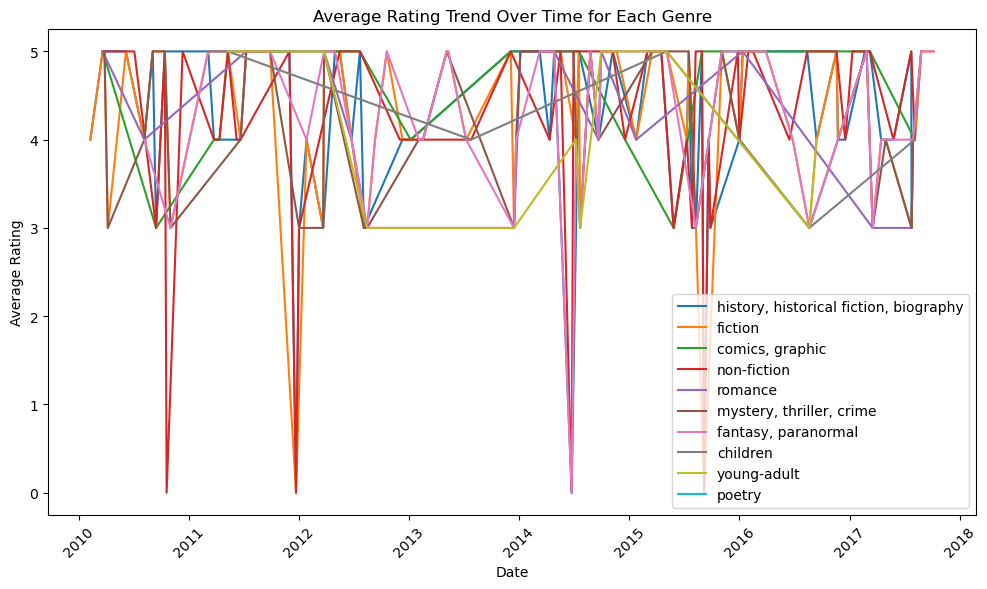

In [34]:
from pyspark.sql.functions import avg

# Group by genre and read_date, calculate average rating, and order by date
result_df = joined_df_refined.groupBy("genre", "read_date").agg(avg("rating").alias("avg_rating")).orderBy("read_date")

# Convert to Pandas DataFrame
result_pd = result_df.toPandas()

# Plotting with Matplotlib
import matplotlib.pyplot as plt

# Plotting for each genre
genres = result_pd['genre'].unique()
plt.figure(figsize=(10, 6))

for genre in genres:
    genre_data = result_pd[result_pd['genre'] == genre]
    plt.plot(genre_data['read_date'], genre_data['avg_rating'], label=genre)

plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating Trend Over Time for Each Genre')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


23/12/20 20:12:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/20 20:12:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


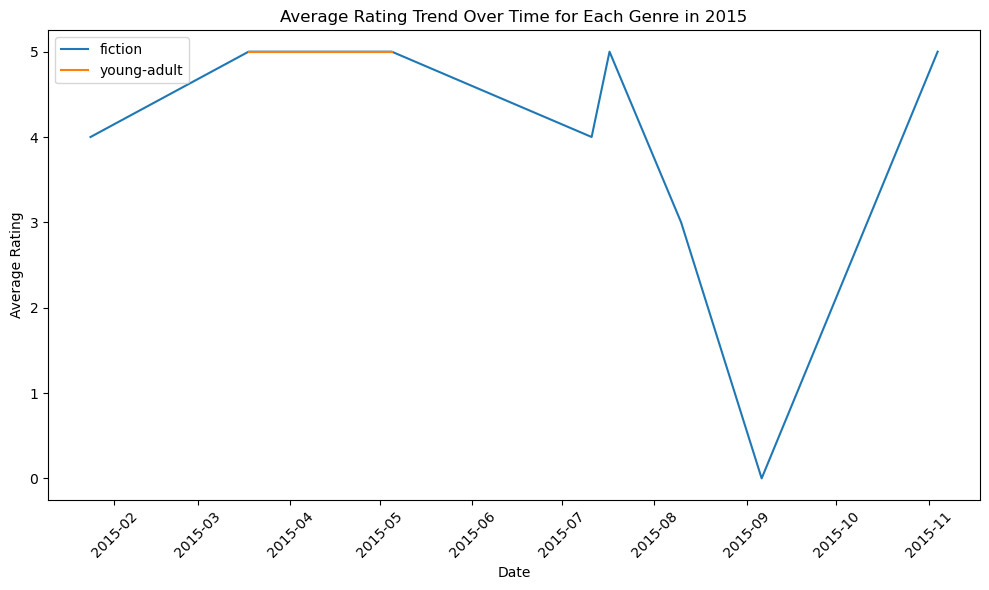

In [35]:
from pyspark.sql.functions import avg, year

# Filter data for a specific year (e.g., 2015)
filtered_df = joined_df_refined.filter(year("read_date") == 2015)

# Group by genre and read_date, calculate average rating, and order by date
result_df = filtered_df.groupBy("genre", "read_date").agg(avg("rating").alias("avg_rating")).orderBy("read_date")

# Convert to Pandas DataFrame
result_pd = result_df.toPandas()

# Plotting with Matplotlib
import matplotlib.pyplot as plt

# Plotting for each genre
genres = result_pd['genre'].unique()
plt.figure(figsize=(10, 6))

selected_genres = ['fiction', 'fantasy', 'young-adult']
    
for genre in genres:
    if genre in selected_genres:    
        genre_data = result_pd[result_pd['genre'] == genre]
        plt.plot(genre_data['read_date'], genre_data['avg_rating'], label=genre)

plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating Trend Over Time for Each Genre in 2015')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
